In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from sklearn.model_selection import train_test_split

import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings 
warnings.filterwarnings('ignore')

# Importing the Pre-processed Tweet dataset which was saved earlier

In [2]:
# Now read the CSV file
df = pd.read_csv('Pre-processed_Tweets.csv')

In [3]:
df.head()

,text,sentiment,word_count,char_count,stemmed_content
0,Sooo SAD I will miss you here in San Diego!!!,0,11,46,sooo sad miss san diego
1,my boss is bullying me...,0,5,25,boss bulli
2,what interview! leave me alone,0,6,31,interview leav alon
3,"Sons of ****, why couldn`t they put them on t...",0,15,75,son put releas alreadi bought
4,2am feedings for the baby are fun when he is a...,1,14,64,feed babi fun smile coo


In [4]:
df.drop(['word_count', 'text','char_count'], axis=1, inplace=True)
df.head()

,sentiment,stemmed_content
0,0,sooo sad miss san diego
1,0,boss bulli
2,0,interview leav alon
3,0,son put releas alreadi bought
4,1,feed babi fun smile coo


In [5]:
# Again checking class distribution of target column
df['sentiment'].value_counts()

sentiment
1    8582
0    7781
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16363 entries, 0 to 16362
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        16363 non-null  int64 
 1   stemmed_content  16358 non-null  object
dtypes: int64(1), object(1)
memory usage: 255.8+ KB


In [7]:
#Descriptive summary of dataset
df.describe()

,sentiment
count,16363.000000
mean,0.524476
std,0.499416
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
df.isnull().sum()
#Dropping the null values
df.dropna(inplace=True)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16358 entries, 0 to 16362
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        16358 non-null  int64 
 1   stemmed_content  16358 non-null  object
dtypes: int64(1), object(1)
memory usage: 383.4+ KB


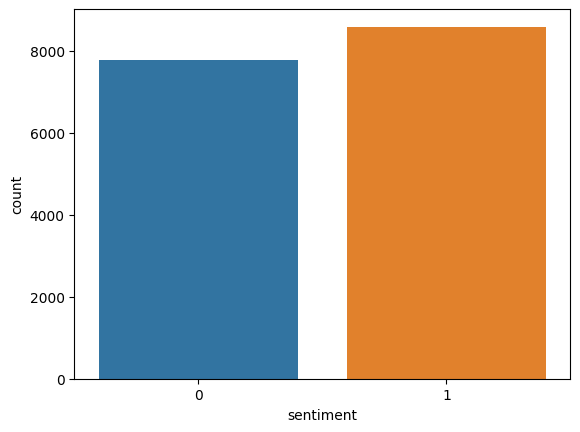

In [10]:
sns.countplot(x=df['sentiment'])
plt.show()

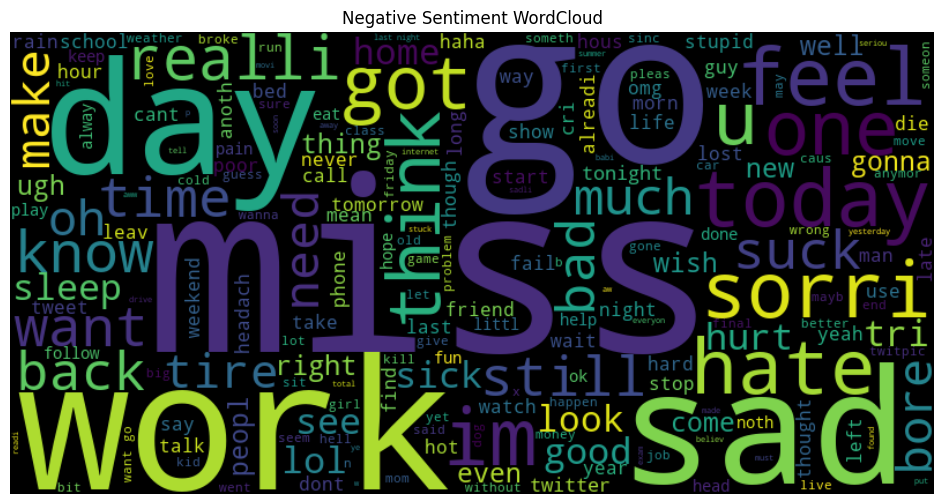

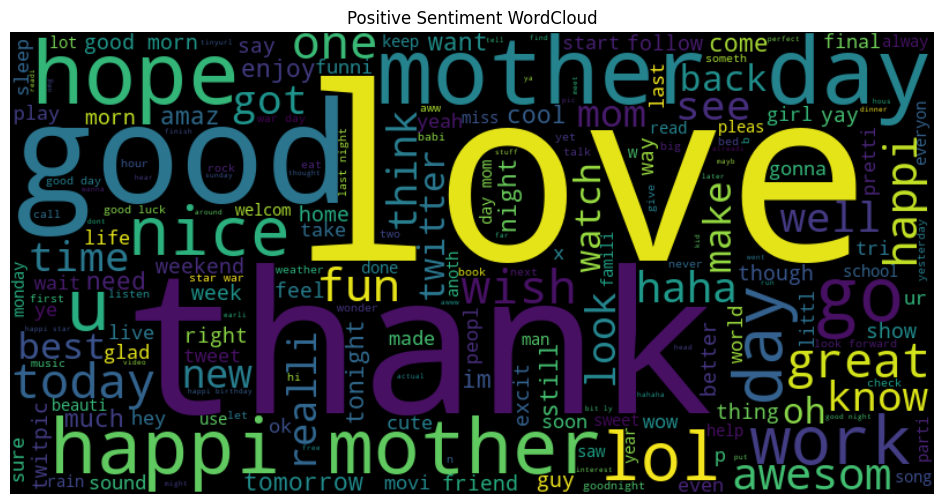

In [11]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 0]
positive_df = df[df['sentiment'] == 1]
# neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['stemmed_content'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black', 
                          width=800, height=400).generate(cleaned_word)
    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
# generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')

# Importing the Frequency table(which was made in logistic regression)

In [12]:
word_frequency = pd.read_csv('Frequency_Table.csv')

In [13]:
word_frequency.head()

,unique_word,positive_frequency,negative_frequency
0,glasser,0,1
1,pleeeeas,1,0
2,tibet,0,1
3,survey,2,2
4,omq,0,1


# Creating Copy of frequency table 

In [14]:
# Creating a copy of this frequency_table
frequency_table_naive_bayes = word_frequency.copy()

# Now adding three new column in this table for naive bayes .
        -> <1>. Conditional  Probability of each unique word in positive class
        -> <2>. Conditional  Probability of each unique word in negative class
        -> <3>. with the help of 1 & 2 calculate log likelihood(lambda score)
                Adding these three column in the word_frequency table and then save it.

In [15]:
# Sum of values in the 'positive' and 'negative' columns
sum_positive = frequency_table_naive_bayes['positive_frequency'].sum()
sum_negative = frequency_table_naive_bayes['negative_frequency'].sum()

# Count of total unique words
total_unique_words = len(frequency_table_naive_bayes)

# Display the results
print(f"Sum of positive values: {sum_positive}")
print(f"Sum of negative values: {sum_negative}")
print(f"Count of total unique words: {total_unique_words}")


Sum of positive values: 382119
Sum of negative values: 328804
Count of total unique words: 14120


# 1. Finding conditional probabilities(Using Laplace smoothing) of each class and add these two column in the frequency_table_naive_bayes 

In [16]:
# (Laplacian smoothing)

# Calculate conditional probabilities for each word
frequency_table_naive_bayes['P(w_i|positive)'] = (frequency_table_naive_bayes['positive_frequency'] + 1) / (sum_positive +  total_unique_words)
frequency_table_naive_bayes['P(w_i|negative)'] = (frequency_table_naive_bayes['negative_frequency'] + 1) / (sum_negative +  total_unique_words)

# Display the updated DataFrame with conditional probabilities
frequency_table_naive_bayes.head()

,unique_word,positive_frequency,negative_frequency,P(w_i|positive),P(w_i|negative)
0,glasser,0,1,0.000003,0.000006
1,pleeeeas,1,0,0.000005,0.000003
2,tibet,0,1,0.000003,0.000006
3,survey,2,2,0.000008,0.000009
4,omq,0,1,0.000003,0.000006


# 2. Calculating the Log-Likelihood(Lambda score) , with the help of the two columns created in step-1

In [17]:
# Log Likelihood function
def log_likelihood(positive_class_prob, negative_class_prob):
    
    # Calculate probability ratio
    ratio_probability = positive_class_prob / negative_class_prob
    
    # Compute lambda score
    lambda_w = np.log(ratio_probability)
    
    return lambda_w

# Apply Laplacian smoothing and compute lambda score for each word
frequency_table_naive_bayes['lambda_score'] = frequency_table_naive_bayes.apply(
    lambda row: log_likelihood(row['P(w_i|positive)'], row['P(w_i|negative)']),
    axis=1
)

# # Save the DataFrame to a CSV file run only one time
# frequency_table_naive_bayes.to_csv('Frequency_table_naive_bayes.csv', index=False)



In [18]:
# Importing the frequency_table_naive_bayes.csv file
frequency_table_naive_bayes = pd.read_csv('Frequency_table_naive_bayes.csv')

In [19]:
# Display the updated DataFrame with lambda scores
frequency_table_naive_bayes.head()

,unique_word,positive_frequency,negative_frequency,P(w_i|positive),P(w_i|negative),lambda_score
0,glasser,0,1,0.000003,0.000006,-0.837656
1,pleeeeas,1,0,0.000005,0.000003,0.548638
2,tibet,0,1,0.000003,0.000006,-0.837656
3,survey,2,2,0.000008,0.000009,-0.144509
4,omq,0,1,0.000003,0.000006,-0.837656


# 3. Calculating log prior

In [20]:
# Step 1: Count the number of positive and negative tweets
num_positive_tweets = sum(df['sentiment'] == 1)
num_negative_tweets = sum(df['sentiment'] == 0)

# Step 2: Calculate the ratio of positive to negative tweets
ratio_pos_neg = num_positive_tweets / num_negative_tweets

# Step 3: Calculate the log prior
log_prior = np.log(ratio_pos_neg)

# Step 4: Save the computed log prior value in a .txt file
with open('log_prior.txt', 'w') as file:
    file.write(str(log_prior))

# Display the results
print(f"Number of positive tweets: {num_positive_tweets}")
print(f"Number of negative tweets: {num_negative_tweets}")
print(f"Ratio of positive to negative tweets: {ratio_pos_neg}")
print(f"Log prior: {log_prior}")


Number of positive tweets: 8581
Number of negative tweets: 7777
Ratio of positive to negative tweets: 1.1033817667481034
Log prior: 0.09837979711217765


# Note - Log prior is not zero indicating that the sentiment class is not balanced (no. of positive and negative tweets are not same) 

# Test the model 

In [21]:
# Taking 2000 dataset from the original one 
negative_sentiment = df[df['sentiment'] == 0].head(1000)
positive_sentiment = df[df['sentiment'] == 1].head(1000)

# Concatenate the balanced dataframes
balanced_data = pd.concat([negative_sentiment, positive_sentiment])

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate the sentiment of each tweet using Naive Bayes classifier
def predict_sentiment(tweet):
    log_prior_positive = np.log(len(positive_sentiment) / len(balanced_data))
    log_prior_negative = np.log(len(negative_sentiment) / len(balanced_data))
    
    log_likelihood_positive = 0
    log_likelihood_negative = 0
    
    # Tokenize the tweet
    tokens = tweet.split()  # Assuming the tweet is already preprocessed and tokenized
    
    # Calculate log likelihood for each word in the tweet
    for word in tokens:
        if word in frequency_table_naive_bayes['unique_word'].values:
            row = frequency_table_naive_bayes[frequency_table_naive_bayes['unique_word'] == word].iloc[0]
            log_likelihood_positive += row['lambda_score']
            log_likelihood_negative -= row['lambda_score']
    
    # Calculate probabilities
    log_prob_positive = log_prior_positive + log_likelihood_positive
    log_prob_negative = log_prior_negative + log_likelihood_negative
    
    # Predict sentiment based on probabilities
    predicted_sentiment = 1 if log_prob_positive > log_prob_negative else 0
    
    return predicted_sentiment

# Apply the predict_sentiment function to each tweet in balanced_data
balanced_data['predicted_sentiment'] = balanced_data['stemmed_content'].apply(predict_sentiment)

# Compare predicted sentiment with actual sentiment
accuracy = accuracy_score(balanced_data['sentiment'], balanced_data['predicted_sentiment'])
precision = precision_score(balanced_data['sentiment'], balanced_data['predicted_sentiment'])
recall = recall_score(balanced_data['sentiment'], balanced_data['predicted_sentiment'])
f1 = f1_score(balanced_data['sentiment'], balanced_data['predicted_sentiment'])

# Print the results
print("Accuracy:", accuracy*100)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 91.35
Precision: 0.9232343909928352
Recall: 0.902
F1 Score: 0.9124936772888215


# Printing the result -

In [23]:
balanced_data.reindex(columns=['stemmed_content', 'sentiment', 'predicted_sentiment'])


,stemmed_content,sentiment,predicted_sentiment
0,got sniffl want get sick need,1,0
1,way work hungri,0,0
2,hook rian van staden twitter much better cook ...,1,1
3,afraid im def product nri karan johar gener wa...,0,0
4,babe woo im get mine monday cant wait x,1,1
...,...,...,...
1995,urg play wow wait week til im dad day til mcfl...,1,1
1996,cont bastard version french fun believ,1,1
1997,oh sorri least still abl buy regular ticket wo...,0,0
1998,wish knew play instrument lesson menac missi m...,1,1


# Testing on user input

In [25]:

# Step 1: Preprocess the input tweet
# Define the Stemming Function
def preprocess_input_tweet(content):
    # Remove non-alphabetic characters using regular expression
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    
    # Convert to lowercase
    stemmed_content = stemmed_content.lower()
    
    # Tokenize the text into words
    stemmed_content = stemmed_content.split()
    
    # Apply stemming using Porter Stemmer, and exclude stopwords
    final_stopwords = set(stopwords.words('english')) - set(['not', 'no', 'against', 'nor'])
    port_stem = PorterStemmer()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in final_stopwords]
    
    # Join the stemmed words into a single string
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

# Step 2: Calculate log likelihood
def calculate_log_likelihood(stemmed_input, word_freq_df):
    # Split the input into words
    words = stemmed_input.split()

    # Initialize likelihoods
    log_likelihood_pos = 0
    log_likelihood_neg = 0

    # Iterate through words and calculate log likelihood
    for word in words:
        if word in word_freq_df['unique_word'].values:
            # Get the lambda score for the word
            lambda_w = word_freq_df.loc[word_freq_df['unique_word'] == word, 'lambda_score'].values[0]
            
            # Update log likelihoods
            log_likelihood_pos += lambda_w if lambda_w > 0 else 0
            log_likelihood_neg += -lambda_w if lambda_w < 0 else 0

    return log_likelihood_pos, log_likelihood_neg

# Step 3: Make predictions
def predict_sentiment(log_likelihood_pos, log_likelihood_neg, log_prior):
    # Calculate the final log likelihoods
    log_likelihood_pos += log_prior
    log_likelihood_neg += log_prior

    # Determine the predicted sentiment class
    predicted_class = 1 if log_likelihood_pos > log_likelihood_neg else 0

    return predicted_class

# Get input tweet from the user
input_tweet = input("Enter a tweet: ")

# Preprocess the input tweet
preprocessed_input = preprocess_input_tweet(input_tweet)

# Calculate log likelihoods
log_likelihood_pos, log_likelihood_neg = calculate_log_likelihood(preprocessed_input, frequency_table_naive_bayes)

# Make predictions
predicted_class = predict_sentiment(log_likelihood_pos, log_likelihood_neg, log_prior)

print("Your Tweet: - ", input_tweet)
# Display the result
if predicted_class == 1:
    print("Positive sentiment!")
else:
    print("Negative sentiment!")


Enter a tweet:  i am bads guy


Your Tweet: -  i am bads guy
Negative sentiment!
